# Plotting mixture models and histograms

In [1]:
%config Completer.use_jedi = False
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
ctcf = pd.read_csv('/home/katie/bp_repo/research/data/cutnrun/temp/fragment_lengths/CTCF_frag_lengths.txt',header=None)[0]
ctcf = np.array(ctcf).reshape((-1,1))
fosl = pd.read_csv('/home/katie/bp_repo/research/data/cutnrun/temp/fragment_lengths/FOSL2_frag_lengths.txt',header=None)[0]
fosl = np.array(fosl).reshape((-1,1))

In [3]:
ctcf_distribution = pd.value_counts(ctcf.ravel().astype(int)).sort_index() / len(ctcf)
fosl_distribution = pd.value_counts(fosl.ravel().astype(int)).sort_index() / len(fosl)

In [4]:
def hellinger_distance(p, q):
    ''' p and q are probability distributions, i.e. a pandas Series that sums up to 1 '''
    return 1/np.sqrt(2) * np.sqrt(np.sum(np.square(np.sqrt(p) - np.sqrt(q))))

In [5]:
def kl_divergence(probs1, probs2):
    """
    Computes the KL divergence in the last dimension of `probs1` and `probs2`
    as KL(P1 || P2). `probs1` and `probs2` must be the same shape. For example,
    if they are both A x B x L arrays, then the KL divergence of corresponding
    L-arrays will be computed and returned in an A x B array. Does not
    renormalize the arrays. If probs2[i] is 0, that value contributes 0.
    
    divergence of P1 with P2 as reference
    """
    quot = np.divide(
        probs1, probs2, out=np.ones_like(probs1),
        where=((probs1 != 0) & (probs2 != 0))
        # No contribution if P1 = 0 or P2 = 0
    )
    return np.sum(probs1 * np.log(quot), axis=-1)

In [6]:
def jensen_shannon_distance(probs1, probs2):
    """
    Computes the Jesnsen-Shannon distance in the last dimension of `probs1` and
    `probs2`. `probs1` and `probs2` must be the same shape. For example, if they
    are both A x B x L arrays, then the KL divergence of corresponding L-arrays
    will be computed and returned in an A x B array. This will renormalize the
    arrays so that each subarray sums to 1. If the sum of a subarray is 0, then
    the resulting JSD will be NaN.
    """
    # Renormalize both distributions, and if the sum is NaN, put NaNs all around
    probs1_sum = np.sum(probs1, axis=-1, keepdims=True)
    probs1 = np.divide(
        probs1, probs1_sum, out=np.full_like(probs1, np.nan),
        where=(probs1_sum != 0)
    )
    probs2_sum = np.sum(probs2, axis=-1, keepdims=True)
    probs2 = np.divide(
        probs2, probs2_sum, out=np.full_like(probs2, np.nan),
        where=(probs2_sum != 0)
    )

    mid = 0.5 * (probs1 + probs2)
    return 0.5 * (kl_divergence(probs1, mid) + kl_divergence(probs2, mid))

### 1. Mixture of normal and normal

Hellinger distance: 0.1240188933382541
JSD: 0.11496255780024359


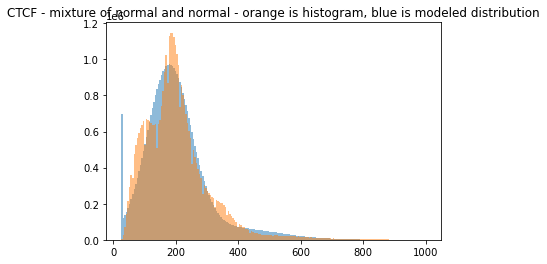

In [8]:
# CTCF
weights = [
        0.8623377674334199,
        0.13766223256658008
    ]

norm0 = stats.norm(loc=178.89298135997063,scale=70.57965782207822)
norm1 = stats.norm(loc=363.4324189285233,scale=155.42236283860737)

ctcf_modeled_data = np.append(norm0.rvs(int(len(ctcf) * weights[0])),
                              norm1.rvs(int(len(ctcf) * weights[1]))).reshape((-1,1))

plt.title('CTCF - mixture of normal and normal - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)
    
# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))


Hellinger distance: 0.21171600756401823
JSD: 0.19495806094900794


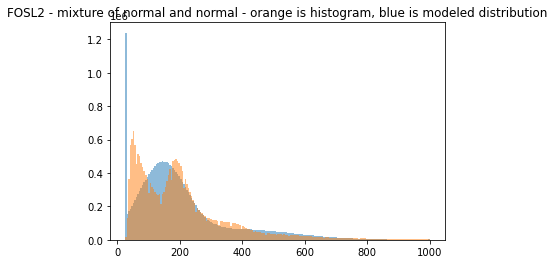

In [9]:
# FOSL2
weights = [
        0.2562428117459429,
        0.7437571882540571
    ]

norm0 = stats.norm(loc=384.6605273084385,scale=181.06852595997933)
norm1 = stats.norm(loc=144.894711345409,scale=74.85341642314572)

fosl_modeled_data = np.append(norm0.rvs(int(len(fosl) * weights[0])),
                              norm1.rvs(int(len(fosl) * weights[1]))).reshape((-1,1))

plt.title('FOSL2 - mixture of normal and normal - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data,26,1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0)), np.array(fosl_distribution))))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))



### 2. Mixture of normal, normal, and normal

Hellinger distance: 0.08432256324658173
JSD: 0.08060856759696627


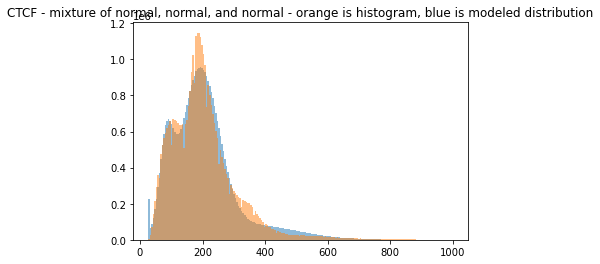

In [10]:
# CTCF
weights = [
        0.127089022950687,
        0.7156974431498625,
        0.1572135338994504
    ]

norm0 = stats.norm(loc=84.43283582192464,scale=21.5431906601662)
norm1 = stats.norm(loc=192.315876204923,scale=60.20087304197669)
norm2 = stats.norm(loc=355.73670703538625,scale=148.71195811532772)

ctcf_modeled_data = np.append(np.append(norm0.rvs(int(len(ctcf) * weights[0])),
                              norm1.rvs(int(len(ctcf) * weights[1]))),
                              norm2.rvs(int(len(ctcf) * weights[2]))).reshape((-1,1))

plt.title('CTCF - mixture of normal, normal, and normal - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)
    
# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))

Hellinger distance: 0.11409748248715641
JSD: 0.1074041022321267


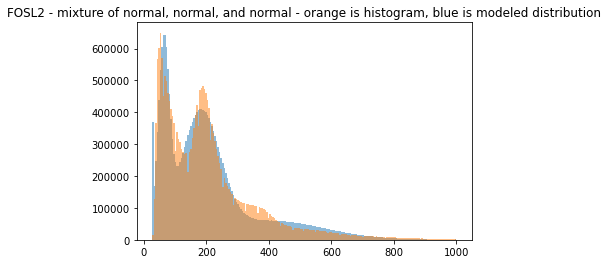

In [11]:
# FOSL2
weights = [
        0.531869422466881,
        0.23204999694766437,
        0.2360805805854547
    ]

norm0 = stats.norm(loc=181.72419369971263,scale=62.025763437882866)
norm1 = stats.norm(loc=63.580813999051784,scale=17.996462917903393)
norm2 = stats.norm(loc=402.08944042718247,scale=175.91295156665277)

fosl_modeled_data = np.append(np.append(norm0.rvs(int(len(fosl) * weights[0])),
                              norm1.rvs(int(len(fosl) * weights[1]))),
                              norm2.rvs(int(len(fosl) * weights[2]))).reshape((-1,1))

plt.title('FOSL2 - mixture of normal, normal, and normal - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data,26,1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))

#print('KL divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(fosl_distribution))))

### 3. Mixture of log normal and log normal

Hellinger distance: 0.050488689702186056
JSD: 0.049207875330561174


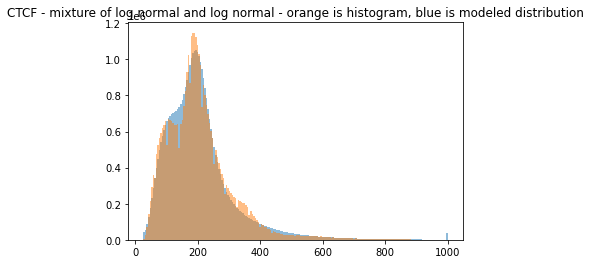

In [12]:
# CTCF
weights = [
        0.77,
        0.23
    ]

lognorm0 = stats.lognorm(scale=np.exp(5.152610764),s=0.5757046357)
lognorm1 = stats.lognorm(scale=np.exp(5.322383247),s=0.1610960448)

ctcf_modeled_data = np.append(lognorm0.rvs(int(len(ctcf) * weights[0])),
                              lognorm1.rvs(int(len(ctcf) * weights[1]))).reshape((-1,1))

plt.title('CTCF - mixture of log normal and log normal - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)
    
# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))

Hellinger distance: 0.09171605637162829
JSD: 0.09029945308585048


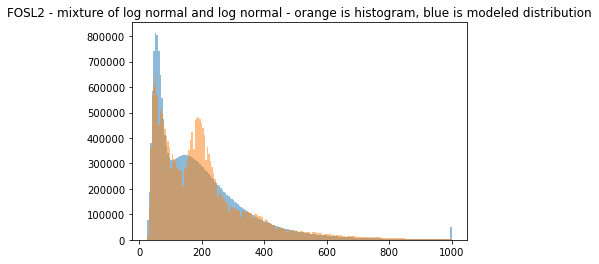

In [13]:
# FOSL2
weights = [
        0.2562428117459429,
        0.7437571882540571
    ]

lognorm0 = stats.lognorm(scale=np.exp(4.051413012),s=0.2746058128)
lognorm1 = stats.lognorm(scale=np.exp(5.32687485),s=0.5709431686)

fosl_modeled_data = np.append(lognorm0.rvs(int(len(fosl) * weights[0])),
                              lognorm1.rvs(int(len(fosl) * weights[1]))).reshape((-1,1))

plt.title('FOSL2 - mixture of log normal and log normal - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data,26,1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(fosl_distribution))))

### 4. Mixture of log normal, log normal, and log normal

Hellinger distance: 0.033395067056248985
JSD: 0.03303596063711918


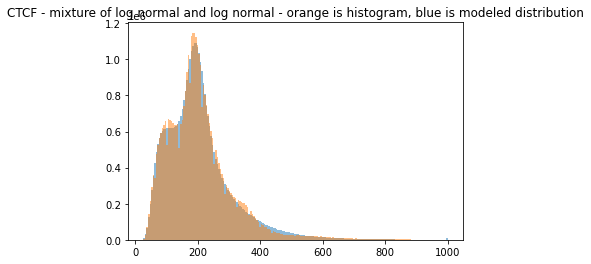

In [14]:
# CTCF
weights = [
        0.1993718142594052,
        0.645354027773805,
        0.15527415796678973
    ]

lognorm0 = stats.lognorm(scale=np.exp(5.288606639041059),s=0.14397978065769745)
lognorm1 = stats.lognorm(scale=np.exp(5.339686537412568),s=0.46935712449344924)
lognorm2 = stats.lognorm(scale=np.exp(4.449709266493632),s=0.35051042911082697)

ctcf_modeled_data = np.append(np.append(lognorm0.rvs(int(len(ctcf) * weights[0])),
                              lognorm1.rvs(int(len(ctcf) * weights[1]))),
                              lognorm2.rvs(int(len(ctcf) * weights[2]))).reshape((-1,1))

plt.title('CTCF - mixture of log normal and log normal - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)
    
# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))

Hellinger distance: 0.05757600043631706
JSD: 0.05384517733254885


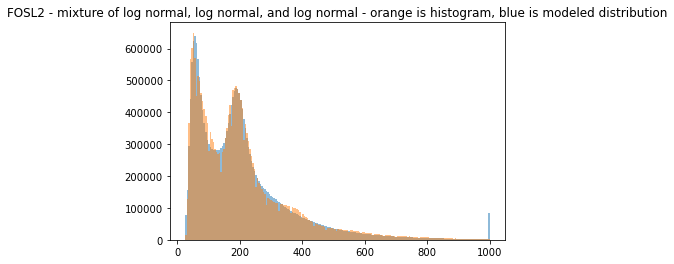

In [15]:
# FOSL2
weights = [
        0.21867538053728314,
        0.11221501529678118,
        0.6691096041659356
    ]

lognorm0 = stats.lognorm(scale=np.exp(4.096235468433135),s=0.30009344531405224)
lognorm1 = stats.lognorm(scale=np.exp(5.2735056050015245),s=0.11654976256729527)
lognorm2 = stats.lognorm(scale=np.exp(5.360580827248132),s=0.6051111108812386)

fosl_modeled_data = np.append(np.append(lognorm0.rvs(int(len(fosl) * weights[0])),
                              lognorm1.rvs(int(len(fosl) * weights[1]))), 
                              lognorm2.rvs(int(len(fosl) * weights[2]))).reshape((-1,1))

plt.title('FOSL2 - mixture of log normal, log normal, and log normal - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data,26,1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(fosl_distribution))))

### 5. Mixture of normal, normal, and log normal

Hellinger distance: 0.05232888331240138
JSD: 0.051501445600064644


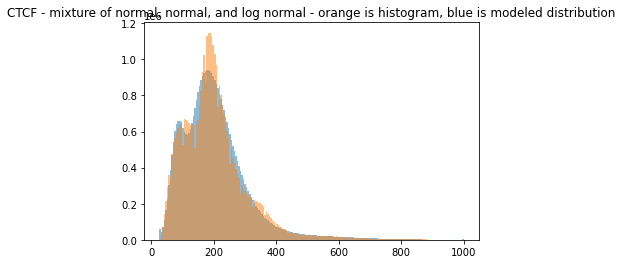

In [16]:
# CTCF
weights = [
        0.04085752013540901,
        0.16490552810614129,
        0.7942369517584497
    ]

norm0 = stats.norm(loc=491.1558,scale=170.57973)
norm1 = stats.norm(loc=82.747177,scale=21.76886)
lognorm = stats.lognorm(scale=np.exp(5.312095), s=0.33829)

ctcf_modeled_data = np.append(np.append(norm0.rvs(int(len(ctcf) * weights[0])),
                              norm1.rvs(int(len(ctcf) * weights[1]))),
                             lognorm.rvs(int(len(ctcf) * weights[2]))).reshape((-1,1))

plt.title('CTCF - mixture of normal, normal, and log normal - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)

# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))

Hellinger distance: 0.08704587623791873
JSD: 0.08495270144671668


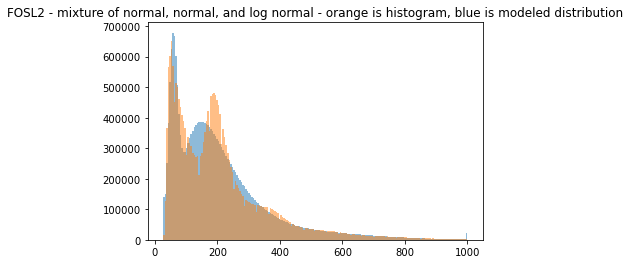

In [17]:
# FOSL2
weights = [
        0.048587826790911934,
        0.194729685309861,
        0.756682487899227
    ]

norm0 = stats.norm(loc=578.038543,scale=173.1678472)
norm1 = stats.norm(loc=57.663748,scale=14.2573062)
lognorm = stats.lognorm(scale=np.exp(5.2655224), s=0.5146665)

fosl_modeled_data = np.append(np.append(norm0.rvs(int(len(fosl) * weights[0])),
                              norm1.rvs(int(len(fosl) * weights[1]))),
                              lognorm.rvs(int(len(fosl) * weights[2]))).reshape((-1,1))

plt.title('FOSL2 - mixture of normal, normal, and log normal - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data, 26, 1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(fosl_distribution))))

### 6. Mixture of normal normal, and exponential

Hellinger distance: 0.19814907441661753
JSD: 0.17637352263065265


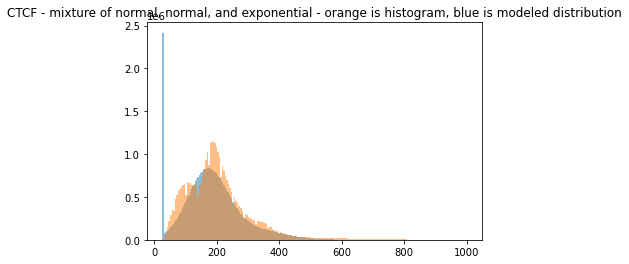

In [18]:
# CTCF
weights = [
        0.7456198019220923,
        0.2040559954299312,
        0.05032420264797656
    ]

norm0 = stats.norm(loc= 169.55473937122946,scale=62.92145896542639)
norm1 = stats.norm(loc=298.6956538503495,scale=102.6555733024736)
expon = stats.expon(scale=0.0029737019591499136)

ctcf_modeled_data = np.append(np.append(norm0.rvs(int(len(ctcf) * weights[0])),
                              norm1.rvs(int(len(ctcf) * weights[1]))),
                             expon.rvs(int(len(ctcf) * weights[2]))).reshape((-1,1))

plt.title('CTCF - mixture of normal, normal, and exponential - orange is histogram, blue is modeled distribution')
bins_ctcf_modeled = plt.hist(np.clip(ctcf_modeled_data,26,1000),bins=200,alpha=0.5)
bins_ctcf_real = plt.hist(ctcf, bins=200,alpha=0.5)

# Hellinger distance
ctcf_modeled_distribution = pd.value_counts(ctcf_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(ctcf_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(ctcf_distribution, ctcf_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0), ctcf_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(ctcf_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(ctcf_distribution))))

Hellinger distance: 0.46925500741695064
JSD: 0.4095354055153399


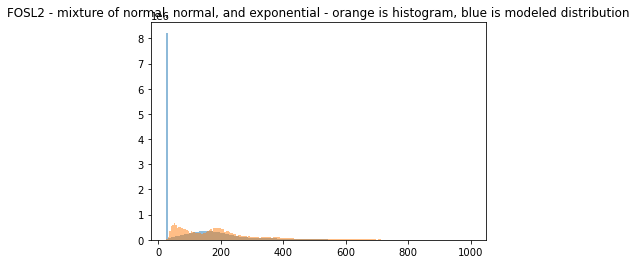

In [19]:
# FOSL2
weights = [
        0.5131271619789958,
        0.1501900522306055,
        0.3366827857903988
    ]

norm0 = stats.norm(loc=150.3794535342574,scale=68.32753506333248)
norm1 = stats.norm(loc=333.1960217217091,scale= 121.99141580806672)
expon = stats.expon(scale=0.004254995755390902)

fosl_modeled_data = np.append(np.append(norm0.rvs(int(len(fosl) * weights[0])),
                              norm1.rvs(int(len(fosl) * weights[1]))),
                              expon.rvs(int(len(fosl) * weights[2]))).reshape((-1,1))

plt.title('FOSL2 - mixture of normal, normal, and exponential - orange is histogram, blue is modeled distribution')
bins_fosl_modeled = plt.hist(np.clip(fosl_modeled_data, 26, 1000),bins=200,alpha=0.5)
bins_fosl_real = plt.hist(fosl, bins=200,alpha=0.5)

# Hellinger distance
fosl_modeled_distribution = pd.value_counts(fosl_modeled_data.clip(26,1000).ravel().astype(int)).sort_index() / len(fosl_modeled_data)
print('Hellinger distance: ' + str(hellinger_distance(fosl_distribution, fosl_modeled_distribution)))
print('JSD: ' + str(scipy.spatial.distance.jensenshannon(fosl_modeled_distribution.reindex(fosl_distribution.index).fillna(0), fosl_distribution)))

#modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), divergence: ' + str(kl_divergence(np.array(fosl_modeled_distribution.reindex(ctcf_distribution.index).fillna(0)), np.array(fosl_distribution))))